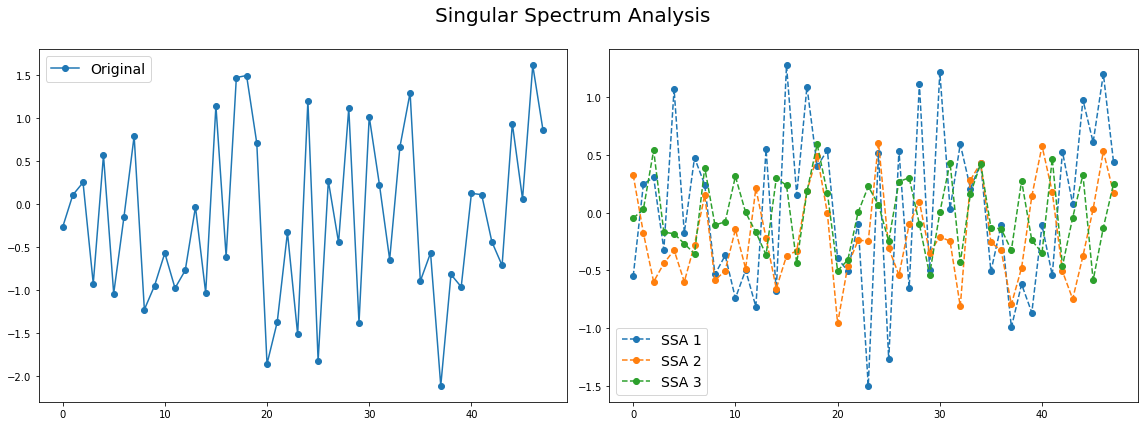

In [1]:
# 分解时间序列
# 原始代码
# Author: Johann Faouzi <johann.faouzi@gmail.com>
# License: BSD-3-Clause

import numpy as np
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis

# Parameters
n_samples, n_timestamps = 100, 48

# Toy dataset
rng = np.random.RandomState(41)
X = rng.randn(n_samples, n_timestamps)

# We decompose the time series into three subseries
window_size = 15
groups = [np.arange(i, i + 5) for i in range(0, 11, 5)]

# Singular Spectrum Analysis
ssa = SingularSpectrumAnalysis(window_size=15, groups=groups)
X_ssa = ssa.fit_transform(X)

# Show the results for the first time series and its subseries
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(121)
ax1.plot(X[0], 'o-', label='Original')
ax1.legend(loc='best', fontsize=14)

ax2 = plt.subplot(122)
for i in range(len(groups)):
    ax2.plot(X_ssa[0, i], 'o--', label='SSA {0}'.format(i + 1))
ax2.legend(loc='best', fontsize=14)

plt.suptitle('Singular Spectrum Analysis', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

# The first subseries consists of the trend of the original time series.
# The second and third subseries consist of noise.

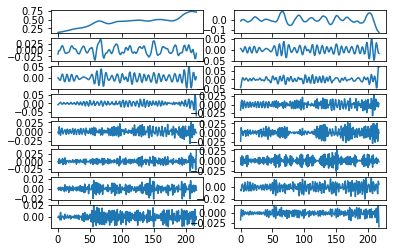

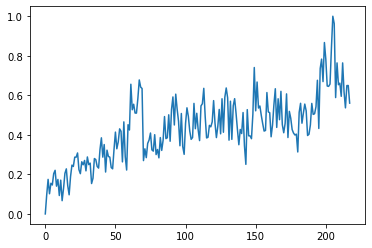

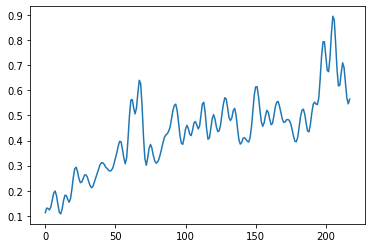

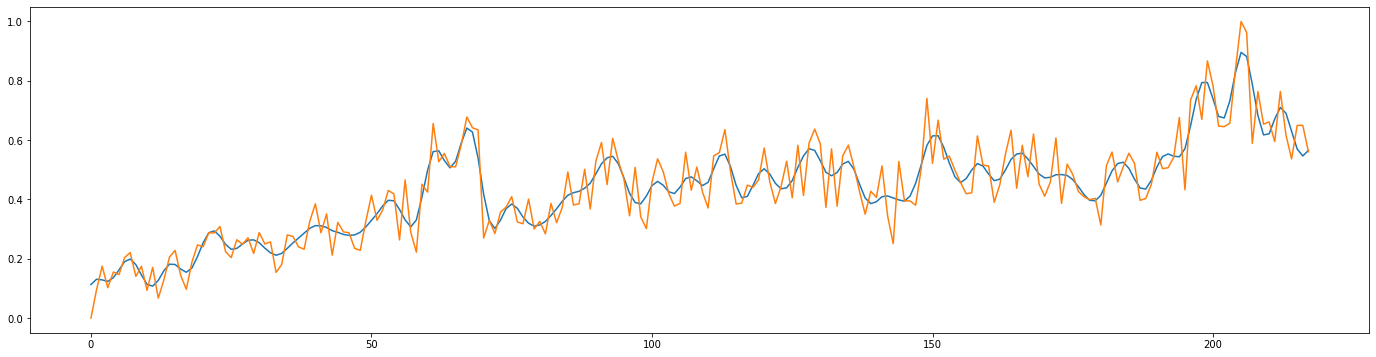

In [63]:
## 2 
## csdn上代码
#!/usr/bin/python3
# -*- coding: utf-8 -*-
# 将最后损伤信号进行奇异值分解
# 
import numpy as np
import matplotlib.pyplot as plt


path = '评价标准/F_proposed.txt'  # 数据集路径

series = np.loadtxt(path)
#series = series - np.mean(series)   # 中心化(非必须)

# step1 嵌入
windowLen = 16             # 嵌入窗口长度
seriesLen = len(series)     # 序列长度
K = seriesLen - windowLen + 1
X = np.zeros((windowLen, K))
for i in range(K):
    X[:, i] = series[i:i + windowLen]

# step2: svd分解， U和sigma已经按升序排序
U, sigma, VT = np.linalg.svd(X, full_matrices=False)

for i in range(VT.shape[0]):
    VT[i, :] *= sigma[i]
A = VT

# 重组
rec = np.zeros((windowLen, seriesLen))
for i in range(windowLen):
    for j in range(windowLen-1):
        for m in range(j+1):
            rec[i, j] += A[i, j-m] * U[m, i]
        rec[i, j] /= (j+1)
    for j in range(windowLen-1, seriesLen - windowLen + 1):
        for m in range(windowLen):
            rec[i, j] += A[i, j-m] * U[m, i]
        rec[i, j] /= windowLen
    for j in range(seriesLen - windowLen + 1, seriesLen):
        for m in range(j-seriesLen+windowLen, windowLen):
            rec[i, j] += A[i, j - m] * U[m, i]
        rec[i, j] /= (seriesLen - j)
        
rrr = np.sum(rec[0:5,:], axis=0)  # 选择重构的部分，这里选了全部

plt.figure()
for i in range(16):
    ax = plt.subplot(8,2,i+1)
    ax.plot(rec[i, :])

plt.figure(2)
plt.plot(series)
plt.show()

plt.figure(3)
plt.plot(rrr)
plt.show()

plt.figure(figsize=(24, 6))
plt.plot(rrr)
plt.plot(series)
plt.show()

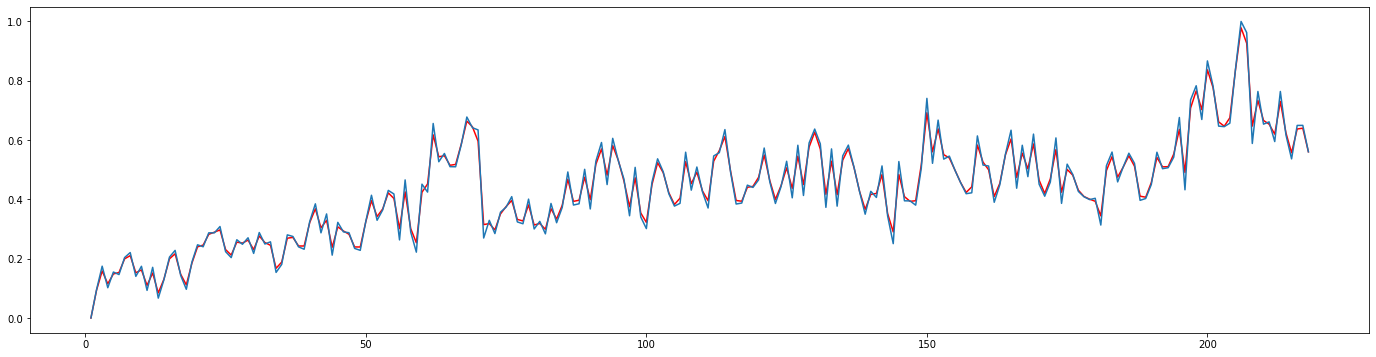

In [47]:
## 进行一个使用奇异值分解的平滑结果与使用局部加权线性回归结果的对比
from numpy import *
import matplotlib.pyplot as plt
 
# 加载数据  返回数据和目标值
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t')) - 1
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat
 
# 利用公式计算回归系数
def standRegres(xArr,yArr):
    xMat = mat(xArr); yMat = mat(yArr).T
    xTx = xMat.T*xMat               # 公式步骤
    if linalg.det(xTx) == 0.0:
        print("行列式为0，奇异矩阵，不能做逆")
        return
    ws = xTx.I * (xMat.T*yMat)  #解线性方程组
    # ws = linalg.solve(xTx,xMat.T*yMat)  # 也可以使用函数来计算 线性方程组
    return ws
 
# 局部加权线性回归 返回该条样本预测值
def lwlr(testPoint,xArr,yArr,k):
    xMat = mat(xArr); yMat = mat(yArr).T
    m = shape(xMat)[0]
    weights = mat(eye((m)))     # 创建为单位矩阵，再mat转换数据格式     因为后面是与原数据矩阵运算，所以这里是为了后面运算且不带来其他影响
    for j in range(m):                      # 利用高斯公式创建权重W     遍历所有数据，给它们一个权重
        diffMat = testPoint - xMat[j,:]                         # 高斯核公式1
        weights[j,j] = exp(diffMat*diffMat.T/(-2.0*k**2))       # 高斯核公式2    矩阵*矩阵.T 转行向量为一个值    权重值以指数级衰减
    xTx = xMat.T * (weights * xMat)                             # 求回归系数公式1
    if linalg.det(xTx) == 0.0:      # 判断是否有逆矩阵
        print("行列式为0，奇异矩阵，不能做逆")
        return
    ws = xTx.I * (xMat.T * (weights * yMat))                    # 求回归系数公式2
    return testPoint * ws
 
# 循环所有点求出所有的预测值
def lwlrTest(testArr,xArr,yArr,k):  # 传入的k值决定了样本的权重，1和原来一样一条直线，0.01拟合程度不错，0.003纳入太多噪声点过拟合了
    m = shape(testArr)[0]
    yHat = zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)      # 返回该条样本的预测目标值
    return yHat
 
xArr,yArr = loadDataSet('D:/我的小桌面/txt11.txt')
# 求所有预测值
#0.5
yHat = lwlrTest(xArr,xArr,yArr,0.5)
#print(yHat)
# 绘制数据点和拟合线（局部加权线性回归）
xMat = mat(xArr)
srtInd = xMat[:,1].argsort(0)   # 画拟合线 需要获得所有横坐标从小到大的下标
xSort = xMat[srtInd][:,0,:] # 获得排序后的数据
 
fig = plt.figure(figsize=(24, 6))
ax = fig.add_subplot(111)
ax.plot(xSort[:,1],yHat[srtInd],color='red')

ax.plot(xMat[:,1].flatten().A[0],mat(yArr).T.flatten().A[0])
plt.show()

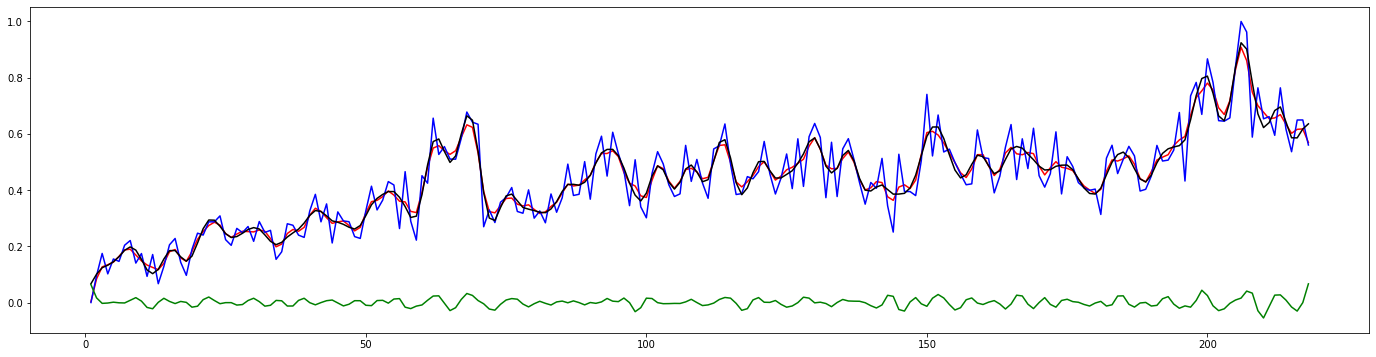

In [60]:
rrr1 = np.sum(rec[0:6,:], axis=0)  # 选择重构的部分，这里选了全部
rrr2 = np.sum(rec[0:6,:], axis=0)  # 选择重构的部分，这里选了全部
yHat = lwlrTest(xArr,xArr,yArr,1.0)
#print(yHat)
# 绘制数据点和拟合线（局部加权线性回归）
xMat = mat(xArr)
srtInd = xMat[:,1].argsort(0)   # 画拟合线 需要获得所有横坐标从小到大的下标
xSort = xMat[srtInd][:,0,:] # 获得排序后的数据



fig = plt.figure(figsize=(24, 6))
ax = fig.add_subplot(111)
ax.plot(xSort[:,1],yHat[srtInd],color='red')
#ax.plot(xMat[:,1].flatten().A[0],mat(yArr).T.flatten().A[0])
ax.plot(xSort[:,1],series,color='blue')
ax.plot(xSort[:,1],rrr1,color='black')
ax.plot(xSort[:,1],rrr1-yHat,color='green')
#ax.plot(xSort[:,1],rrr2,color='orange')
plt.show()

In [62]:
### 使用奇异值分解的方法增加了平滑的可解释性
### 之后可以构建一个三维图体现这种分解方式

In [ ]:
### 与其他评价因子进行比对
